Running GA1: tournament, arithmetic, gaussian
Saved: GA1_results.csv
Running GA2: roulette, uniform, swap
Saved: GA2_results.csv
Running GA3: random, arithmetic, reset
Saved: GA3_results.csv


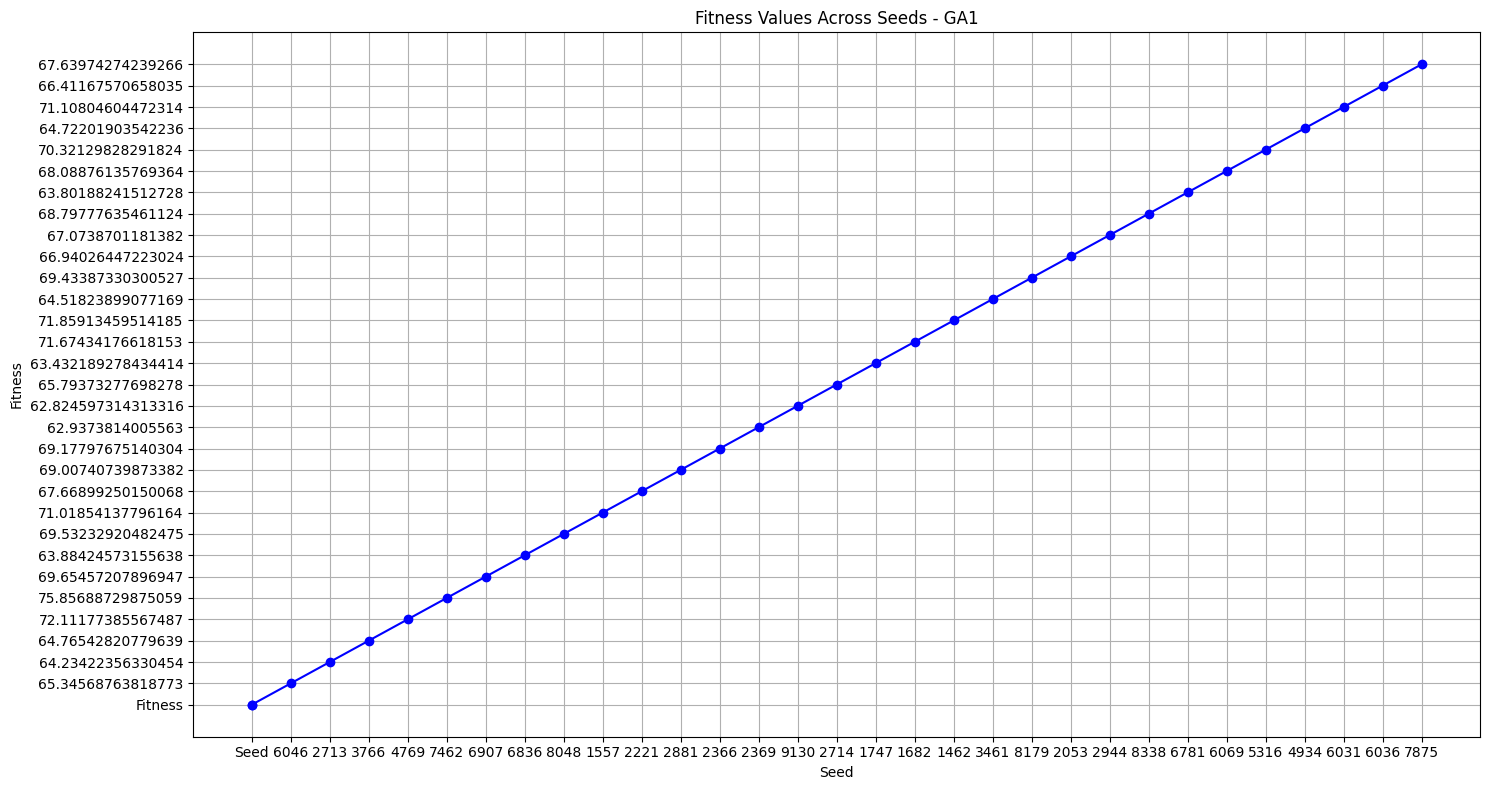

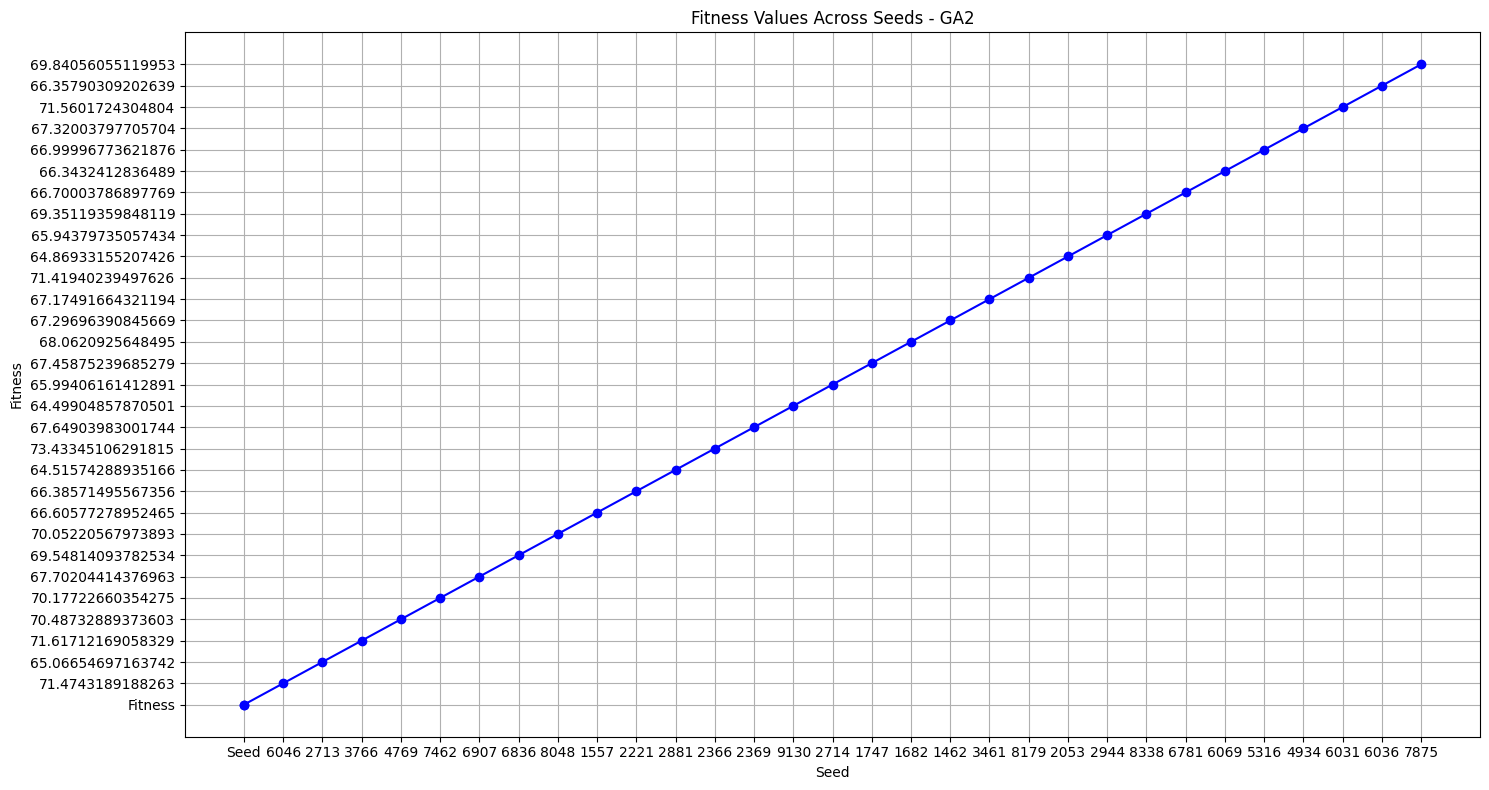

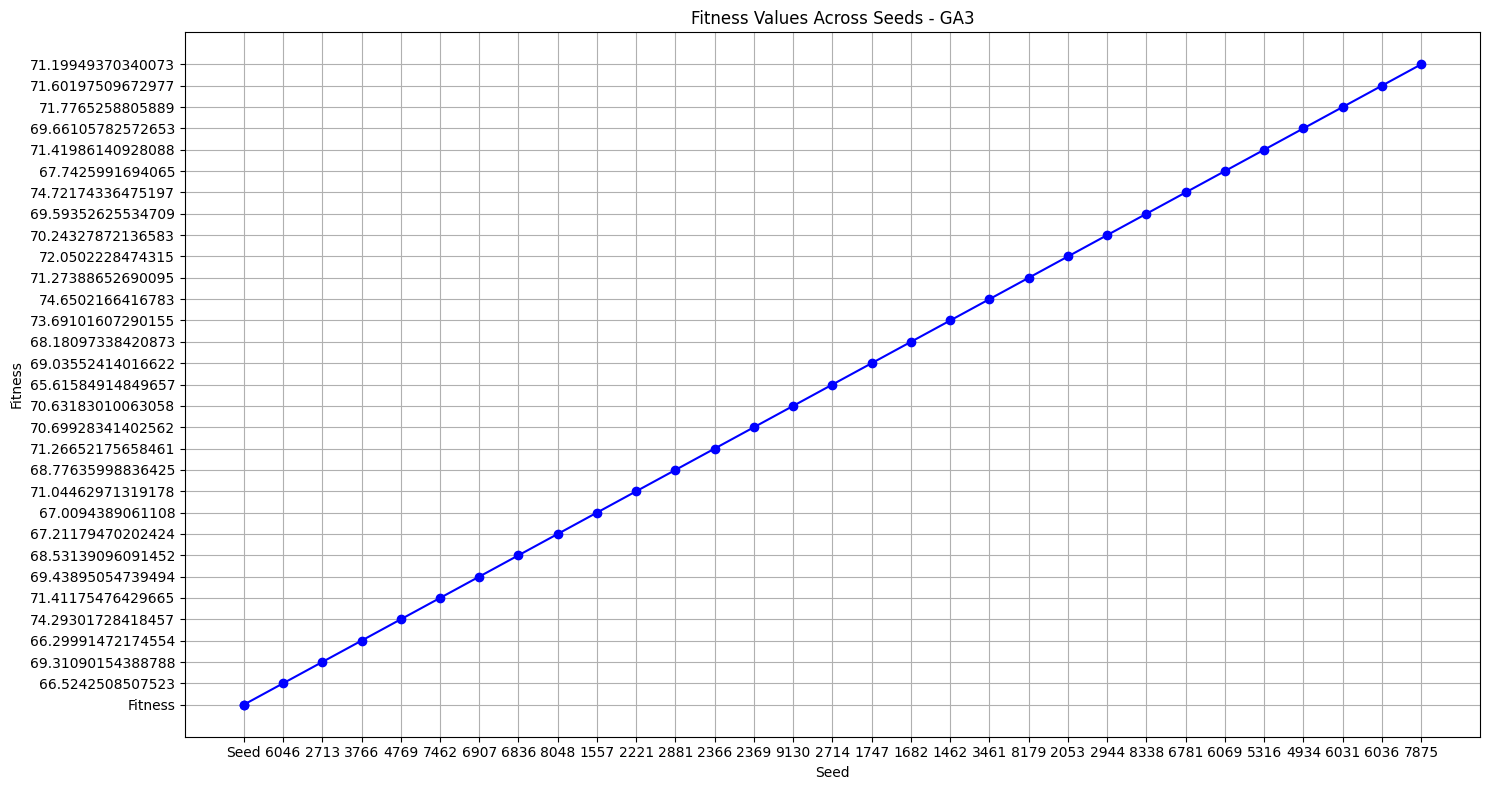


Best Result from GA1 | Fitness: 62.8246 | Silhouette: 0.3512


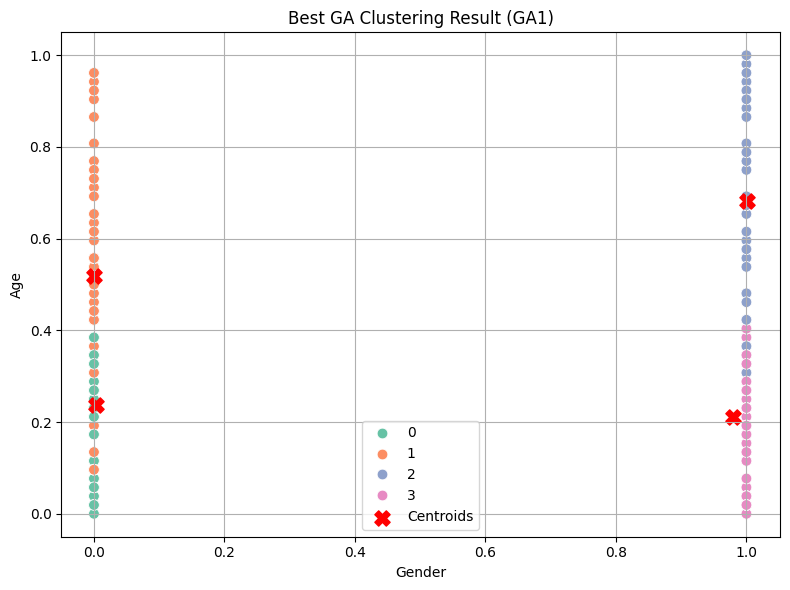

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df_scaled = pd.read_csv("mall_customers_preprocessed.csv")
X = df_scaled.values
n_features = X.shape[1]
k_clusters = 4

# --- GA Components ---
def compute_fitness(centroids, data):
    labels = np.argmin(np.linalg.norm(data[:, np.newaxis] - centroids, axis=2), axis=1)
    return np.sum(np.linalg.norm(data - centroids[labels], axis=1))

def initialize_population(pop_size, k, n_features, data_min, data_max):
    return [np.random.uniform(data_min, data_max, (k, n_features)) for _ in range(pop_size)]

def tournament_selection(pop, fits, size=3):
    selected = np.random.choice(len(pop), size, replace=False)
    return pop[selected[np.argmin([fits[i] for i in selected])]]

def roulette_selection(pop, fits):
    fits = np.array(fits)
    inv_fits = 1 / (fits + 1e-10)
    probs = inv_fits / inv_fits.sum()
    idx = np.random.choice(len(pop), p=probs)
    return pop[idx]

def random_selection(pop, fits=None):
    return pop[np.random.randint(len(pop))]

def arithmetic_crossover(p1, p2):
    alpha = np.random.rand()
    return alpha * p1 + (1 - alpha) * p2

def uniform_crossover(p1, p2):
    mask = np.random.rand(*p1.shape) > 0.5
    return np.where(mask, p1, p2)

def gaussian_mutation(centroids, rate=0.1):
    for i in range(centroids.shape[0]):
        if np.random.rand() < rate:
            centroids[i] += np.random.normal(0, 0.05, centroids.shape[1])
    return centroids

def swap_mutation(centroids, rate=0.1):
    if np.random.rand() < rate:
        i, j = np.random.choice(centroids.shape[0], 2, replace=False)
        centroids[i], centroids[j] = np.copy(centroids[j]), np.copy(centroids[i])
    return centroids

def reset_mutation(centroids, rate=0.1):
    for i in range(centroids.shape[0]):
        for j in range(centroids.shape[1]):
            if np.random.rand() < rate:
                centroids[i][j] = np.random.rand()
    return centroids

# --- GA Function ---
def run_ga(seed, selection, crossover, mutation, pop_size=20, generations=50, rate=0.1, immigrants=2):
    np.random.seed(seed)
    data_min, data_max = X.min(axis=0), X.max(axis=0)
    pop = initialize_population(pop_size, k_clusters, n_features, data_min, data_max)
    fits = [compute_fitness(ind, X) for ind in pop]

    for _ in range(generations):
        new_pop = []
        for _ in range(pop_size - immigrants):
            if selection == "tournament":
                p1, p2 = tournament_selection(pop, fits), tournament_selection(pop, fits)
            elif selection == "roulette":
                p1, p2 = roulette_selection(pop, fits), roulette_selection(pop, fits)
            else:
                p1, p2 = random_selection(pop), random_selection(pop)

            if crossover == "arithmetic":
                child = arithmetic_crossover(p1, p2)
            else:
                child = uniform_crossover(p1, p2)

            if mutation == "gaussian":
                child = gaussian_mutation(child, rate)
            elif mutation == "swap":
                child = swap_mutation(child, rate)
            else:
                child = reset_mutation(child, rate)

            new_pop.append(child)

        new_pop += initialize_population(immigrants, k_clusters, n_features, data_min, data_max)
        new_fits = [compute_fitness(ind, X) for ind in new_pop]
        pop += new_pop
        fits += new_fits
        best_idx = np.argsort(fits)[:pop_size]
        pop = [pop[i] for i in best_idx]
        fits = [fits[i] for i in best_idx]

    best = np.argmin(fits)
    best_solution = pop[best]
    labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - best_solution, axis=2), axis=1)
    sil = silhouette_score(X, labels)
    return fits[best], sil, best_solution, labels

# --- Seeds ---
seeds = np.random.choice(range(1000, 10000), 30, replace=False)
with open("seeds_used.txt", "w") as f:
    for s in seeds:
        f.write(str(s) + "\n")

# --- Settings to run ---
settings = [
    ("GA1", "tournament", "arithmetic", "gaussian"),
    ("GA2", "roulette", "uniform", "swap"),
    ("GA3", "random", "arithmetic", "reset")
]

# --- Run All ---
best_overall = (None, float("inf"), None, None, None)  # name, fitness, centroids, labels, sil

for name, sel, cross, mut in settings:
    print(f"Running {name}: {sel}, {cross}, {mut}")
    results = []
    for seed in seeds:
        fitness, sil, centroids, labels = run_ga(seed, sel, cross, mut)
        results.append((seed, fitness, sil, sel, cross, mut))
        if fitness < best_overall[1]:
            best_overall = (name, fitness, centroids, labels, sil)
    df = pd.DataFrame([(r[0], r[1], r[2]) for r in results], columns=["Seed", "Fitness", "SilhouetteScore"])
    df.attrs = {"Selection": sel, "Crossover": cross, "Mutation": mut}
    # Write settings as header lines
    with open(f"{name}_results.csv", "w") as f:
        f.write(f"# Selection: {sel}# Crossover: {cross}# Mutation: {mut}\n")
        f.write("Seed,Fitness,SilhouetteScore\n")
        f.write("Seed,Fitness,SilhouetteScore\n")
    df.to_csv(f"{name}_results.csv", mode='a', index=False)
    print(f"Saved: {name}_results.csv")

# --- Plot Fitness Evaluation Over Seeds ---
for name in ["GA1", "GA2", "GA3"]:
    df = pd.read_csv(f"{name}_results.csv", comment='#')
    plt.figure(figsize=(15, 8))
    plt.plot(df['Seed'], df['Fitness'], marker='o', linestyle='-', color='blue')
    plt.title(f"Fitness Values Across Seeds - {name}")
    plt.xlabel("Seed")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Plot Best Result ---
print(f"\nBest Result from {best_overall[0]} | Fitness: {best_overall[1]:.4f} | Silhouette: {best_overall[4]:.4f}")
df_scaled['Cluster'] = best_overall[3]
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled.iloc[:, 0], y=df_scaled.iloc[:, 1], hue=best_overall[3], palette='Set2', s=60)
plt.scatter(best_overall[2][:, 0], best_overall[2][:, 1], c='red', marker='X', s=120, label='Centroids')
plt.title(f'Best GA Clustering Result ({best_overall[0]})')
plt.xlabel(df_scaled.columns[0])
plt.ylabel(df_scaled.columns[1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Note :- 
# Let’s say:

# You are clustering into k = 4 clusters

# Your data has 4 features: Gender, Age, Annual Income, Spending Score

# Then each cluster center is a vector of 4 values.
# So, an individual = 4 cluster centers = a 4 x 4 matrix.